Import Libraries

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
import os


Download NLTK Resources

In [43]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jeand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load the Raw Dataset

In [44]:

file_path = "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv"
df = pd.read_csv(file_path)


print(f"Original shape: {df.shape}")

df[['reviews.text', 'reviews.rating']].dropna()
df[df['reviews.text'].str.strip() != '']
df[df['reviews.title'].str.strip() != '']
df['full_review'] = df['reviews.title'].fillna('') + ' - ' + df['reviews.text'].fillna('')
df.rename(columns={'reviews.text': 'text', 'reviews.rating': 'rating','reviews.doRecommend' : 'doRecommend'}, inplace=True)
print(f"After removing missing: {df.shape}")
df.head(3)

# After first columns exploration here are the columns we will drop as they do not provide useful information for future activities
columntodrop = ["id","dateAdded","dateUpdated","keys","manufacturer","manufacturerNumber","reviews.date","reviews.dateAdded","reviews.dateSeen","reviews.id","reviews.numHelpful","reviews.sourceURLs","reviews.text","reviews.title","reviews.username"]
df.drop(columns=columntodrop, inplace=True, errors='ignore')
print(f"After removing columns: {df.shape}")

##Remove DUplicates 
print(f"Number of duplicate reviews: {df.duplicated(subset=['text']).sum()}")
df = df.drop_duplicates(subset=['text'])
print(f"Shape after dropping duplicates: {df.shape}")

Original shape: (5000, 24)
After removing missing: (5000, 25)
After removing columns: (5000, 11)
Number of duplicate reviews: 615
Shape after dropping duplicates: (4385, 11)


Visualize Ratings Distribution

C:\Users\jeand\AppData\Local\Temp\ipykernel_54880\2570993220.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


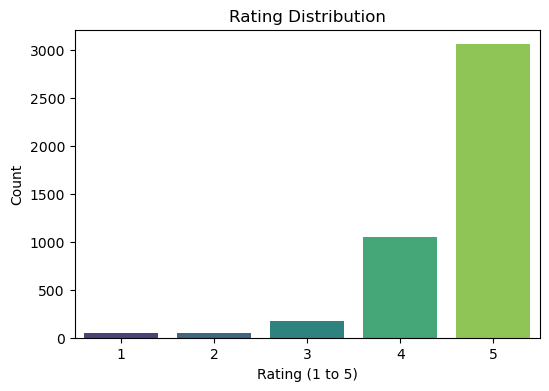

In [45]:
plt.figure(figsize=(6, 4))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title("Rating Distribution")
plt.xlabel("Rating (1 to 5)")
plt.ylabel("Count")
plt.show()


Map Ratings to Sentiment Labels

C:\Users\jeand\AppData\Local\Temp\ipykernel_54880\1546905546.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='coolwarm')


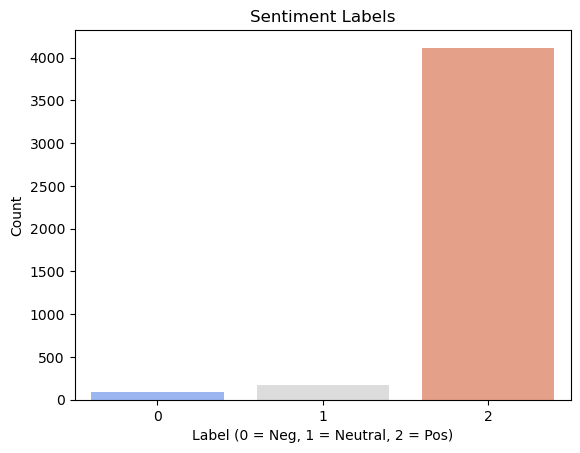

In [46]:
def rating_to_label(r):
    if r in [1, 2]:
        return 0 
    elif r == 3:
        return 1  
    else:
        return 2  

df['label'] = df['rating'].apply(rating_to_label)


sns.countplot(x='label', data=df, palette='coolwarm')
plt.title("Sentiment Labels")
plt.xlabel("Label (0 = Neg, 1 = Neutral, 2 = Pos)")
plt.ylabel("Count")
plt.show()


Clean Text (Simple + Stopwords + Stemming)

In [47]:
def simple_clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

df['clean_text'] = df['text'].apply(simple_clean_text)
df[['text', 'clean_text']].sample(3)


,text,clean_text
4115,"My daughter loves this kindle, she does so muc...",daughter love kindl much itwel worth money
3647,My grandchildren are home schooled and utilize...,grandchildren home school util tabl mani learn...
1726,This was bought as a replacement to a shattere...,bought replac shatter screen kindl alway happi...


Top Common Words per Sentiment Class

In [48]:
def get_top_n_words(texts, n=15):
    all_words = ' '.join(texts).split()
    return pd.DataFrame(Counter(all_words).most_common(n), columns=['word', 'count'])

for label, sentiment in zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
    print(f"\n🔹 Top words for {sentiment} reviews:")
    top_words = get_top_n_words(df[df['label'] == label]['clean_text'])
    print(top_words)



🔹 Top words for Negative reviews:
       word  count
0       use     37
1    amazon     31
2      work     26
3       buy     26
4    tablet     26
5       app     23
6    bought     22
7       one     21
8     would     20
9     devic     19
10    kindl     18
11   return     17
12     time     16
13      get     16
14  product     15

🔹 Top words for Neutral reviews:
      word  count
0   tablet     66
1     good     46
2     work     46
3      use     42
4    great     33
5     echo     29
6      app     27
7     like     26
8     time     26
9     read     25
10     one     25
11  amazon     25
12   would     24
13     kid     23
14     get     22

🔹 Top words for Positive reviews:
       word  count
0      love   1476
1     great   1364
2       use   1308
3    tablet   1138
4      easi    708
5      echo    643
6     kindl    629
7    bought    629
8       one    624
9    amazon    561
10     good    527
11     like    517
12     read    502
13     work    497
14  purchas    465


Word Cloud per Sentiment Class

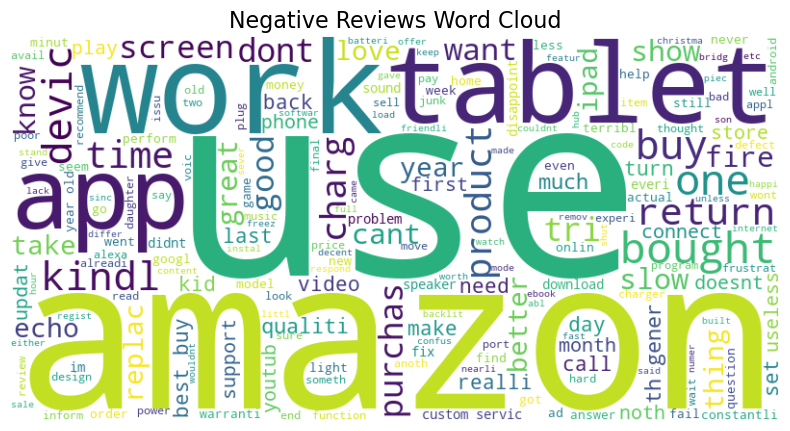

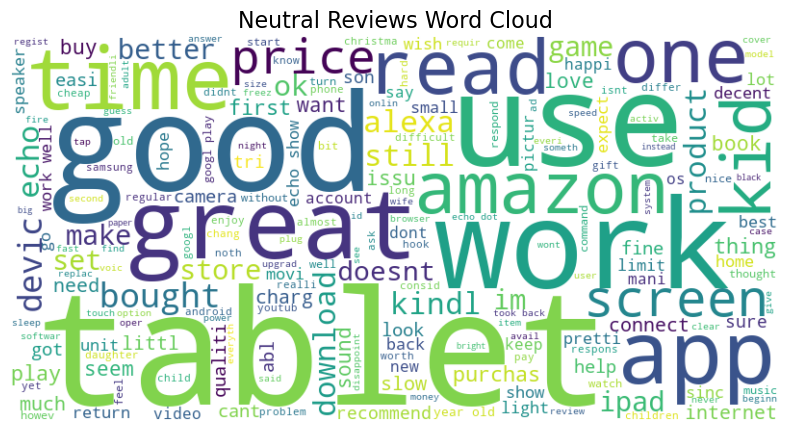

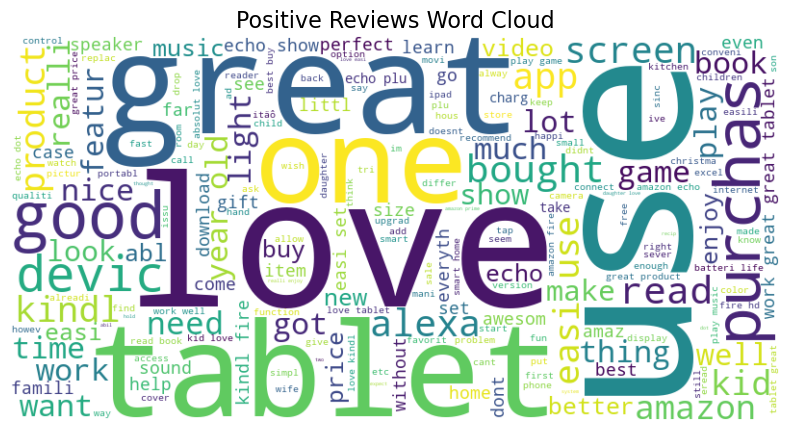

In [49]:
def plot_wordcloud(texts, title):
    text = ' '.join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

for label, sentiment in zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
    plot_wordcloud(df[df['label'] == label]['clean_text'], f"{sentiment} Reviews Word Cloud")


Save the Final Cleaned Dataset

In [50]:
os.makedirs("data", exist_ok=True)
df.to_csv("data/cleaned_amazon_reviews_final.csv", index=False)
print("✅ Saved: data/cleaned_amazon_reviews_final.csv")

✅ Saved: data/cleaned_amazon_reviews_final.csv
